# Simulating wavefront sensing with photonic lantern

This tutorial is on simulating photonic lantern outputs, but assuming the input scene is a point source and phase aberration is introduced.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PLsim import simulator as sim
from PLsim import lantern as l
from PLsim import scene as s

The ``PLOverlapCalculator`` class calculates the spatial modes of the multimode input of the lantern and decomposes focal-plane light in this mode basis. One needs to input the properties of the beam (unobstructed circular aperture is assumed) and the lantern's multimode geometry and refractive indices (LP modes are assumed, with the geometry of circular step-index fiber). 

For the default refractive index settings, about 6 um core radius gives 3-moded lantern, 10 um gives 6-moded lantern, and 16.5 um gives 19-moded lantern.

In [2]:
# let's simulate 6-port lantern
oc = sim.PLOverlapCalculator(dim = 385, # defines the resolution of the grid. use odd numbers.
                             telescope_diameter = 10, # in meters
                             wavelength = 1.55e-6, # in meters
                             nclad = 1.444, # lantern core refractive index
                             njack = 1.444 - 5.5e-3, # lantern cladding refractive index
                             rclad = 10e-6, # lantern core radius in meters,
                             #  focal_length = 53, # focal length in meters. if not provided,
                             # it searches for the focal length that gives the best coupling efficiency.
                             )

Available modes:  [(0, 1, 'cos'), (1, 1, 'cos'), (1, 1, 'sin'), (2, 1, 'cos'), (2, 1, 'sin'), (0, 2, 'cos')]
Calculated k0, V, modes
LP modes stored in self.u0s
Start Focal length optimization
Initial focal length = 4.300e+01
Optimal focal length at 4.29347e+01, with efficiency = 0.885
Coupling efficiency: 0.8853395401099992
Pupil functions calculated and stored in self.u0s_pupil


Now define the lantern's transfer matrix and the ``Device`` class. Let's assume a mode-selective lantern, which has an identity matrix.

In [3]:
U = np.identity(6)
device_PL = sim.Device(lantern_matrix = U, verbose=False)

Simulation of point source response is done by computing overlaps using ``oc.compute_overlap``.

In [4]:
# point source position in radians
xpos = 0 
ypos = 0

overlap = oc.compute_overlap(xpos, ypos) # exactly on-axis

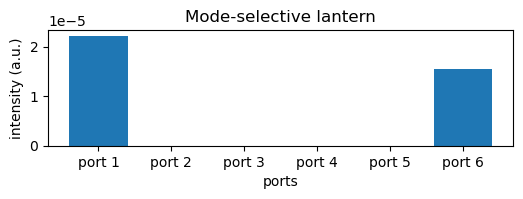

In [5]:
intens = device_PL.calculate_output_intensities(overlap)[0][0]
plt.figure(figsize=(6,1.5))
plt.bar(range(len(intens)), intens)
plt.xlabel('ports')
plt.xticks(range(len(intens)), ['port 1', 'port 2', 'port 3', 'port 4', 'port 5', 'port 6'])
plt.ylabel('intensity (a.u.)')
plt.title('Mode-selective lantern')
plt.show()

### Now add aberration! 

A custom phase screen can be applied using `oc.aberrate(phase_screen)`.

Or for simple Zernike aberrations can be applied by first calculating Zernike phase screens with `oc.prop.prepare_zernikes(N_upto)` and then with `oc.aberrate_zernike(amplitudes)`.

In [6]:
# prepare Zernike aberrations up to 3rd order: tip/tilt/defocus
oc.prop.prepare_zernikes(upto=3)

In [7]:
# apply aberration: 0.5 radian RMS of defocus
oc.aberrate_zernike(amplitudes=[0, 0, 0.5])  # in radians RMS)

In [8]:
# compute overlap with aberration
overlap_aber = oc.compute_overlap(xpos, ypos)

# make sure to remove aberration for future calculations
oc.unaberrate()

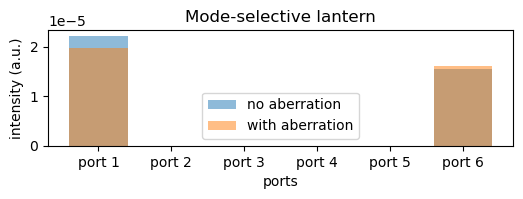

In [9]:
# calculate output intensities with aberration
intens_aber = device_PL.calculate_output_intensities(overlap_aber)[0][0]

plt.figure(figsize=(6,1.5))
plt.bar(range(len(intens)), intens, alpha=0.5, label='no aberration')
plt.bar(range(len(intens_aber)), intens_aber, alpha=0.5, label='with aberration')
plt.xlabel('ports')
plt.xticks(range(len(intens_aber)), ['port 1', 'port 2', 'port 3', 'port 4', 'port 5', 'port 6'])
plt.ylabel('intensity (a.u.)')
plt.title('Mode-selective lantern')
plt.legend()
plt.show()

### how linear is the response to Zernike aberrations?

Let's test five modes: tip/tilts, defocus, and astig

In [10]:
# prepare Zernike aberrations up to 5th order: tip/tilt/defocus/astig
aber_N = 5
oc.prop.prepare_zernikes(upto=aber_N)

aber_names= ['tip', 'tilt', 'defocus', 'astig1', 'astig2']

Also test another lantern with a random unitary matrix

In [11]:
from scipy.stats import unitary_group
np.random.seed(123456)
U_random = unitary_group.rvs(6)

device_PL_random = sim.Device(lantern_matrix = U_random, verbose=False)

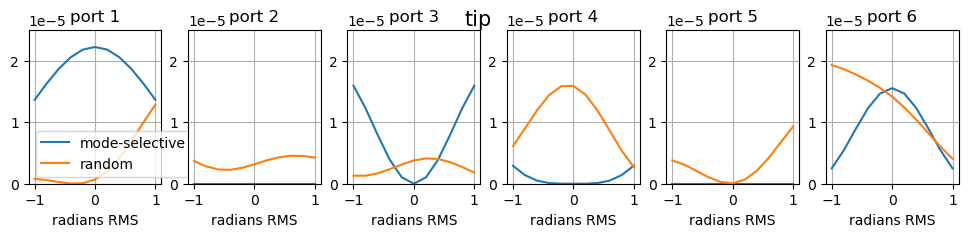

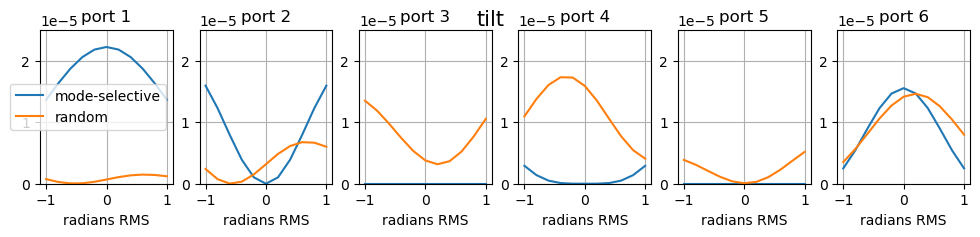

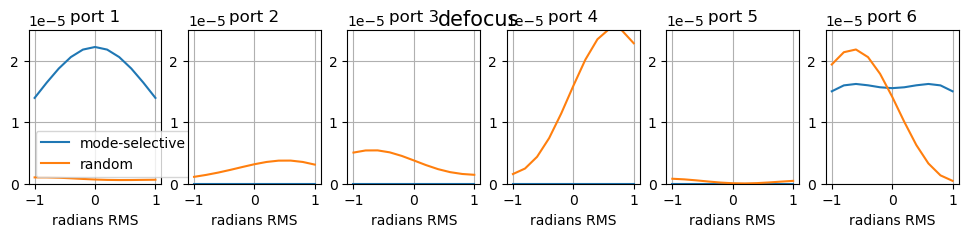

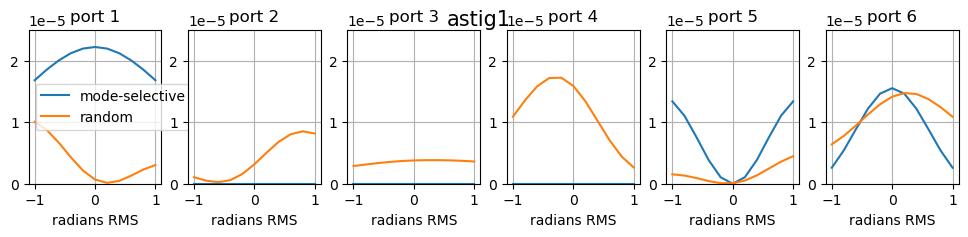

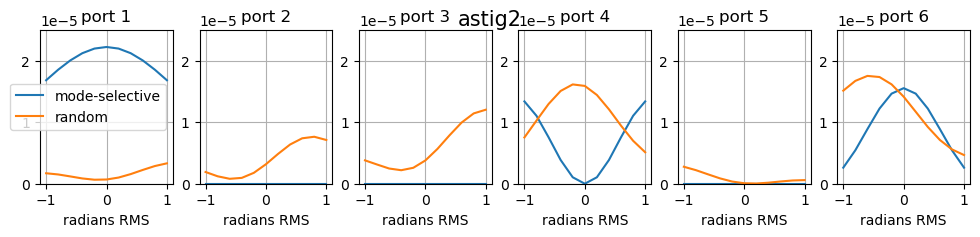

In [14]:
amps = np.linspace(-1, 1, 11) # in radians RMS

for aber_ind in range(aber_N):
    intens_aber_list = []
    intens_random_aber_list = []

    for amp in amps:

        # make amplitude array
        amplitudes = [0]*aber_N
        amplitudes[aber_ind] = amp

        # calculate overlaps with aberration
        oc.aberrate_zernike(amplitudes)
        overlap_aber = oc.compute_overlap(xpos, ypos)
        oc.unaberrate()

        # calculate intensities for two lanterns
        intens_aber = device_PL.calculate_output_intensities(overlap_aber)[0][0]
        intens_aber_list.append(intens_aber)

        intens_random_aber = device_PL_random.calculate_output_intensities(overlap_aber)[0][0]
        intens_random_aber_list.append(intens_random_aber)

    intens_aber_list = np.array(intens_aber_list)
    intens_random_aber_list = np.array(intens_random_aber_list)

    fig, axs = plt.subplots(ncols=6, figsize=(12,2))
    for port_ind in range(intens_aber_list.shape[1]):
        axs[port_ind].plot(amps, intens_aber_list[:, port_ind], label='mode-selective')
        axs[port_ind].plot(amps, intens_random_aber_list[:, port_ind], label='random')
        axs[port_ind].set_xlabel('radians RMS')
        # axs[port_ind].set_ylabel('output intensity (a.u.)')
        axs[port_ind].set_title(f'port {port_ind+1}')
        axs[port_ind].grid()
        axs[port_ind].set_ylim([0, 2.5e-5])
        
    axs[0].legend()
    fig.suptitle(f'{aber_names[aber_ind]}', fontsize=15)
    plt.show()
